In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10 
%pylab inline 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import sys
sys.path.append("../utils")

from utils_3d import *
from sfm import *

import copy

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load data 

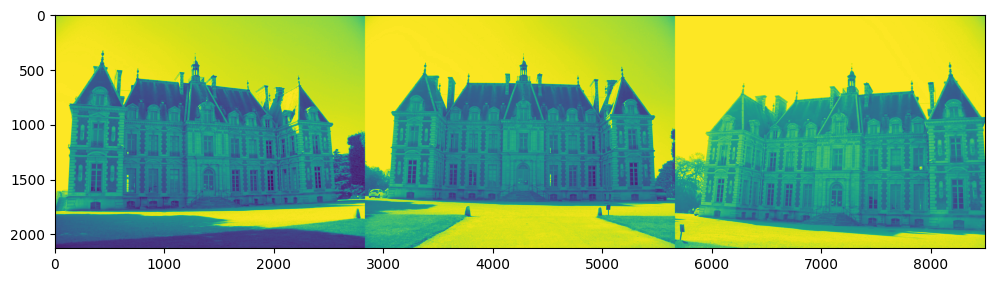

In [2]:
# sample dataset directory
sample_data_path = "../ImageDataset_SceauxCastle/images/"

K = np.loadtxt(os.path.join(sample_data_path,"K.txt"))

# For calculation Essential Matrix
im0 = cv2.imread(os.path.join(sample_data_path,"100_7101.JPG"))
im1 = cv2.imread(os.path.join(sample_data_path,"100_7104.JPG"))
# For Pnp
im2 = cv2.imread(os.path.join(sample_data_path,"100_7107.JPG"))

sfm3view = Sfm3view(K,np.eye(3),np.zeros(3),im0,im1,im2)
imshow(np.hstack([sfm3view.views[0].im_gray,sfm3view.views[1].im_gray,sfm3view.views[2].im_gray]))

# matching sift

In [3]:
# key point detect view0 and view1
sfm3view.detectKeyPoints(0)
sfm3view.detectKeyPoints(1)

In [4]:
# matching keypoint between view1 and view2
match_pair = sfm3view.matchingKeyPointsOf2views(0,1)
print(len(match_pair))
print(len(sfm3view.match_manage_table))

# compute essential matrix by ransac epipolar
sfm3view.solveEpipolarEqToGetEssentialMatrix(0,1)
print(len(sfm3view.match_manage_table))

Create New matching table
386
386
386
386


In [ ]:
work = sfm3view
img_good_matches_inliers = cv2.drawMatches(work.views[0].im_gray,work.views[0].key_point_uvs,work.views[1].im_gray,work.views[1].key_point_uvs,match_pair[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

# Extract R ,t by Fundamental matrix and K
* F = K^(-T)EK^(-1)
* E = K^(T)FK
* E= [t]xR

In [6]:
w_v1Pv2,v2Rv1,v1Lmks,inlier_mask = sfm3view.decomposeE2Rt_and_calc_Xs_wrt_v1(0,1)

(325, 2)
candidate idx:3
inlier mask len: (325,)
match manage table shape: 386


# view

[[ 0.94624511 -0.02238755 -0.32267476]
 [ 0.03656309  0.99861101  0.03793665]
 [ 0.32137726 -0.04769535  0.94574934]]
[ 0.99072414 -0.05418752 -0.124617  ]


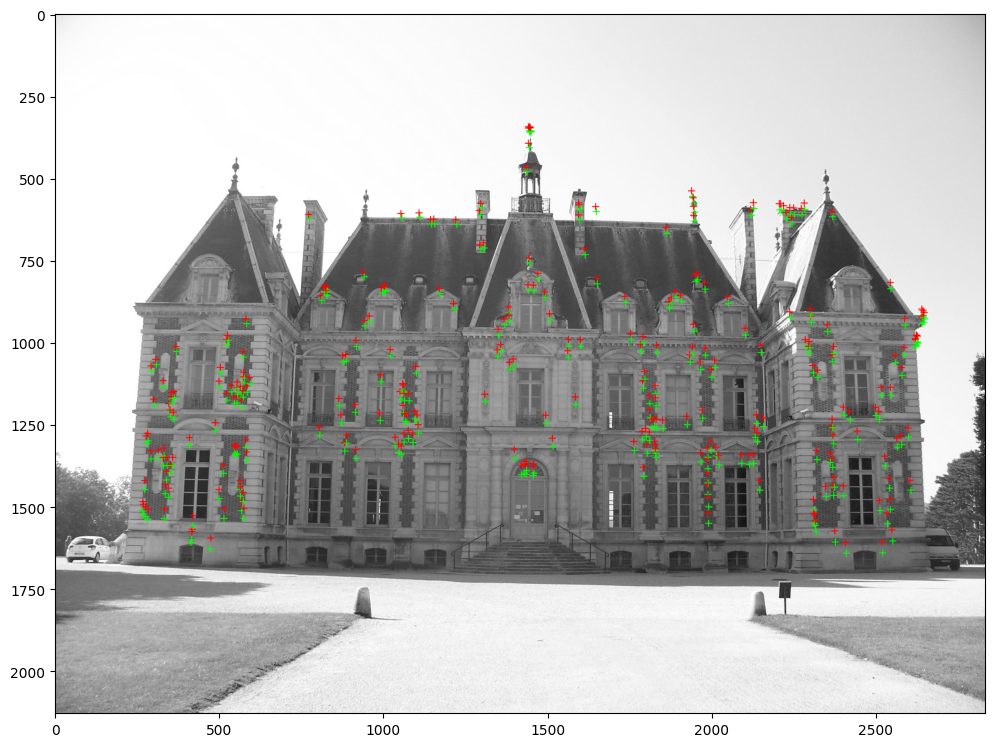

In [7]:
canvas = sfm3view.check_reprojected_points(1,verbose=False)
imshow(canvas)
print(sfm3view.views[1].R)
print(sfm3view.views[1].t)


# Third View PNP

In [8]:
# matching v1 and v2
sfm3view.detectKeyPoints(2)
v2_v3_match_pair = sfm3view.matchingKeyPointsOf2views(1,2)

New 266 points are added.


In [9]:
wPv3,wRv3 = sfm3view.solvePNPToGet_v1Tv2(1,2)

[ 0.99072414 -0.05418752 -0.124617  ]
[-1.80982843  0.16725012  0.76613953]


(314.26080097114016, 1391.0868322470187) [ 320 1368]
(543.6169467100233, 1305.7454102807224) [ 550 1277]
(521.2017037841549, 1685.5445429419594) [ 521 1684]
(526.7481567037939, 1706.6036926091936) [ 526 1707]
(919.0464458832188, 830.2284087147052) [929 791]
(974.8109879465584, 1391.765571498593) [ 978 1384]
(1203.5365570659858, 800.26876102986) [1211  767]
(1057.5229944433147, 1297.324168773302) [1062 1285]
(1116.802437974976, 1478.9491032471155) [1118 1477]
(1142.4283306534687, 1479.4524804354842) [1142 1477]
(1366.0424184625492, 802.3241198828085) [1375  771]
(1418.702063163419, 872.9883570589412) [1426  845]
(1607.3385008462237, 487.29258628404443) [1618  448]
(1403.0536091120414, 1103.7615846939268) [1410 1080]
(1470.5305818393124, 1578.0561016503655) [1470 1581]
(1495.813568477888, 1573.4624401373546) [1496 1576]
(1606.5953640075982, 1196.6678532338976) [1611 1179]
(1646.6099503483708, 1157.1272202527978) [1653 1138]
(1903.5261641542397, 1505.5648433665767) [1901 1506]
(1918.84219

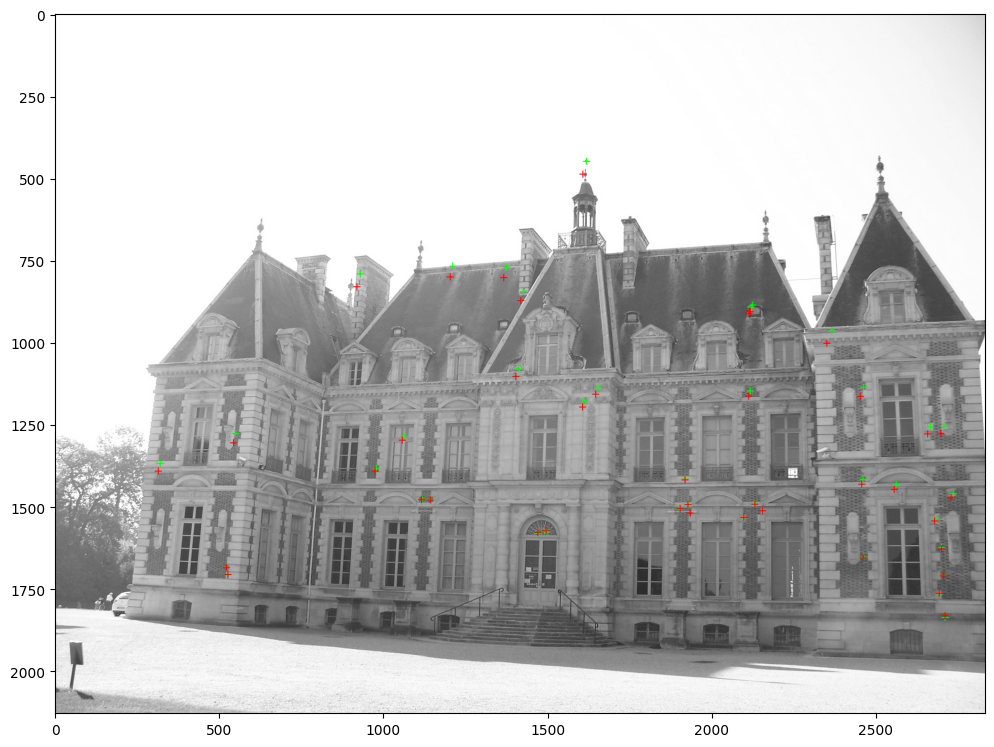

In [10]:
img_good_matches_inliers = cv2.drawMatches(sfm3view.views[1].im_gray,sfm3view.views[1].key_point_uvs,sfm3view.views[2].im_gray,sfm3view.views[2].key_point_uvs,v2_v3_match_pair[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

canvas = sfm3view.check_reprojected_points(2,verbose=True)
imshow(canvas)

In [11]:
out_pcl_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test2.ply"
out_camera_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera2.ply"

wPv1 = np.array([0,0,0])
wRv1 = np.eye(3)

pts2,wLmks,_ = sfm3view.get2D_3Dcoresspondance(1,2,True)

wLmks = wRv1.dot(v1Lmks.T).T + wPv1
save_3dpoints_ply(wLmks,out_pcl_file_name,[255,0,0])

wRv2 = wRv1.dot(v2Rv1.T)
wPv2 = wPv1 + wRv2.dot(w_v1Pv2)

Ps = np.array([wPv1,wPv2,wPv3])
Rs= np.array([wRv1,wRv2,wRv3])

generate_multiple_camera_ply(Ps,Rs,out_camera_file_name,[0,255,0],False)

# BA

In [12]:
sfm3view.BA = BundleAdjust(sfm3view.K)

In [13]:
sfm3view.make3viewGraphForBA()

(41, 3) (41, 3, 2)
0 210.97890220177274 1218.8851788149987
0 [ 210.97119141 1194.46435547]
1 300.6038703357917 1172.7634777567812
1 [ 302.11721802 1192.84265137]
2 314.2608009711399 1391.0868322470187
2 [ 320.50982666 1368.02868652]
0 556.1805492885836 1124.7315949740682
0 [ 555.81463623 1103.93066406]
1 574.3839665697453 1090.506183262977
1 [ 576.90917969 1108.5958252 ]
2 543.6169467100232 1305.7454102807224
2 [ 550.21337891 1277.98583984]
0 558.364934727121 1614.1987021903115
0 [ 559.34387207 1578.79675293]
1 568.8446070272748 1483.1660457906312
1 [ 568.11877441 1512.57824707]
2 521.2017037841548 1685.5445429419594
2 [ 521.03149414 1684.51538086]
0 565.2057353591418 1641.0960430366322
0 [ 566.76251221 1603.93041992]
1 575.0748449148643 1504.650112127562
1 [ 574.72332764 1535.05834961]
2 526.7481567037939 1706.6036926091938
2 [ 526.46234131 1707.42797852]
0 588.5923329136134 577.3286037740361
0 [587.50970459 565.37390137]
1 772.8313903394704 610.7286900897425
1 [775.5760498  621.11071

In [14]:
sfm3view.optimizeBA(100)

Performing full BA:


iteration= 0	 chi2= 4222.800180	 time= 0.000222816	 cumTime= 0.000222816	 edges= 123	 schur= 1	 lambda= 407.362000	 levenbergIter= 1
iteration= 1	 chi2= 4004.999566	 time= 6.6816e-05	 cumTime= 0.000289632	 edges= 123	 schur= 1	 lambda= 135.787333	 levenbergIter= 1
iteration= 2	 chi2= 3937.497099	 time= 6.0448e-05	 cumTime= 0.00035008	 edges= 123	 schur= 1	 lambda= 45.262444	 levenbergIter= 1
iteration= 3	 chi2= 3917.027285	 time= 5.8464e-05	 cumTime= 0.000408544	 edges= 123	 schur= 1	 lambda= 15.087481	 levenbergIter= 1
iteration= 4	 chi2= 3911.747625	 time= 5.808e-05	 cumTime= 0.000466624	 edges= 123	 schur= 1	 lambda= 5.029160	 levenbergIter= 1
iteration= 5	 chi2= 3910.263300	 time= 5.7824e-05	 cumTime= 0.000524448	 edges= 123	 schur= 1	 lambda= 1.676387	 levenbergIter= 1
iteration= 6	 chi2= 3909.319144	 time= 5.728e-05	 cumTime= 0.000581728	 edges= 123	 schur= 1	 lambda= 0.558796	 levenbergIter= 1
iteration= 7	 chi2= 3908.590799	 time= 5.7952e-05	 cumTime= 0.00063968	 edges= 123	 sc

In [15]:
sfm3view.updatePoseToResultOfBA()

 3906.726649	 time= 5.712e-05	 cumTime= 0.00178278	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 28	 chi2= 3906.714851	 time= 5.6896e-05	 cumTime= 0.00183968	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 29	 chi2= 3906.704098	 time= 5.7024e-05	 cumTime= 0.0018967	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 30	 chi2= 3906.694292	 time= 5.6896e-05	 cumTime= 0.0019536	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 31	 chi2= 3906.685347	 time= 5.7184e-05	 cumTime= 0.00201078	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 32	 chi2= 3906.677185	 time= 5.712e-05	 cumTime= 0.0020679	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 33	 chi2= 3906.669733	 time= 5.6768e-05	 cumTime= 0.00212467	 edges= 123	 schur= 1	 lambda= 0.000000	 levenbergIter= 1
iteration= 34	 chi2= 3906.662926	 time= 5.6608e-05	 cumTime= 0.00218128	 edges= 123	 schur= 1	 lambda= 0.000000	 le

In [16]:

Rs_ba = []
Ps_ba = []
for i in range(3):
    R = sfm3view.views[i].R_
    t = sfm3view.views[i].t_
    Rs_ba.append(R)
    Ps_ba.append(t)

Rs_ba = np.array(Rs_ba)
Ps_ba = np.array(Ps_ba)

_,_,_,lmks,_ = sfm3view.get3Viewcoresspondance(0,1,2,True)

In [17]:
out_pcl_ba_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test6_ba.ply"
out_camera_ba_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera6_ba.ply"

save_3dpoints_ply(lmks,out_pcl_ba_file_name,[100,100,155])
generate_multiple_camera_ply(Ps_ba,Rs_ba,out_camera_ba_file_name,[0,100,155],False)

In [18]:
wPxs_new = sfm3view.landmark_propagation(1,2)
out_pcl_prop_new_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_prop_new.ply"
save_3dpoints_ply(wPxs_new,out_pcl_prop_new_file_name,[120,0,255])


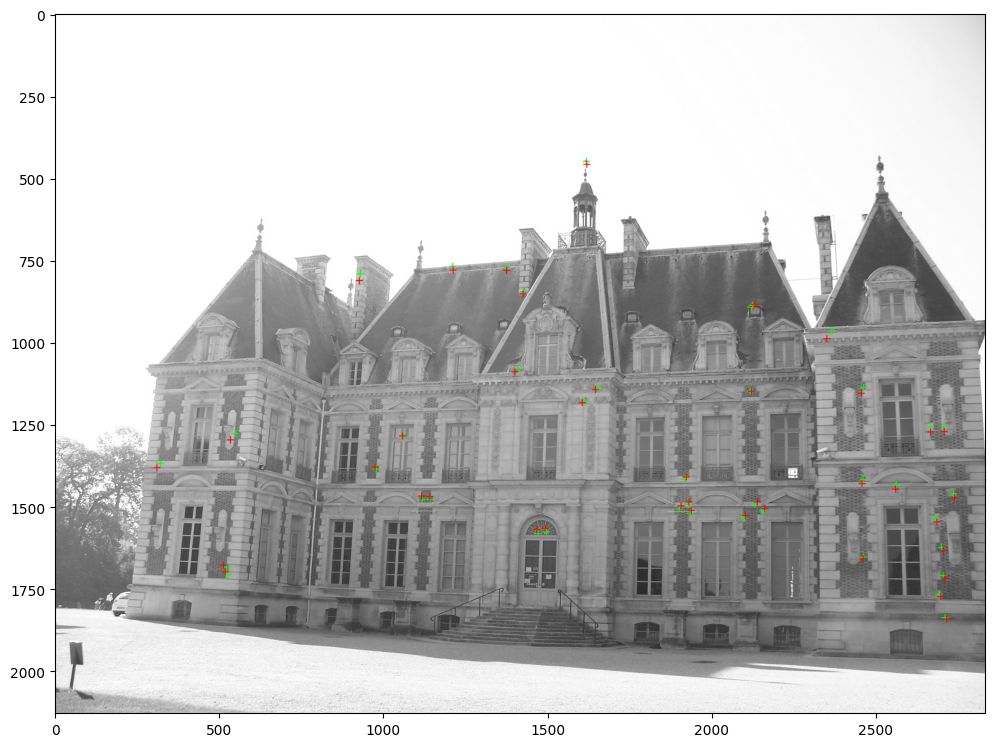

In [19]:
canvas = sfm3view.check_reprojected_points(2)
imshow(canvas)